In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from core import bw_color_palette
import textwrap

In [2]:
def plot_upset(data, x_list, y, hue, figsize=(8, 6), palette=None, subplot_fraction=0.25,
               lower_bound=None, upper_bound=None, legend_title='', bar_ylabel=None, 
               marker_size=4, legend_text_width=30):
    """
    Creates an UpSet plot using matplotlib.

    Parameters:
    - data: pandas DataFrame containing the data.
    - x_list: list of column names in data representing boolean variables.
    - y: the name of the numeric column in data.
    - hue: the name of the categorical column in data.
    - figsize: tuple specifying the figure size (width, height).
    - palette: list of colors for the bar plot.
    - subplot_fraction: fraction of the figure height allocated to the combination matrix.
    - lower_bound: optional, the name of the column for the lower bound of y.
    - upper_bound: optional, the name of the column for the upper bound of y.

    The function plots a bar for each hue across combinations of x variables,
    with the height of the bar representing the y variable for that hue/x set.
    Error bars are included if lower_bound and upper_bound are provided.
    """
    # Create a 'combination' column that represents the combination of x_list variables
    data['combination'] = data[x_list].apply(lambda row: tuple(row.values), axis=1)

    # Get unique combinations and generate labels
    combinations = data['combination'].unique()
    combination_labels = []
    for comb in combinations:
        label = ' & '.join([x_list[i] for i, val in enumerate(comb) if val])
        if not label:
            label = 'None'
        combination_labels.append(label)

    # Create a DataFrame for combinations
    combination_df = pd.DataFrame({
        'combination': combinations,
        'label': combination_labels
    })
    combination_df['combination_id'] = range(len(combinations))
    combination_dict = {comb: idx for comb, idx in zip(combinations, combination_df['combination_id'])}
    data['combination_id'] = data['combination'].map(combination_dict)

    # Aggregate y (and bounds if provided) per combination_id and hue
    agg_columns = [y]
    if lower_bound and upper_bound:
        agg_columns.extend([lower_bound, upper_bound])

    agg_data = data.groupby(['combination_id', hue])[agg_columns].sum().reset_index()

    # Pivot data to have hues as columns
    agg_pivot = agg_data.pivot(index='combination_id', columns=hue).fillna(0)

    # Compute total y per combination for ordering
    agg_pivot['total_y'] = agg_pivot[y].sum(axis=1)

    # Sort combinations by total y descending
    agg_pivot = agg_pivot.sort_values('total_y', ascending=False)

    # Update combination_df to match sorted combination_ids
    combination_df = combination_df.set_index('combination_id').loc[agg_pivot.index].reset_index()

    # Prepare plotting data
    hues = agg_pivot[y].columns.tolist()
    num_combinations = len(agg_pivot)
    x = np.arange(num_combinations)  # x-axis positions
    width = 0.8 / len(hues)  # width of each bar

    # Prepare colors
    if palette is not None:
        colors = palette
    else:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    fig, (ax_bar, ax_upset) = plt.subplots(
        2, 1, figsize=figsize,
        gridspec_kw={'height_ratios': [1 - subplot_fraction, subplot_fraction]},
        sharex=True
    )

    # Plot bars for each hue with error bars if provided
    for i, hue_value in enumerate(hues):
        y_values = agg_pivot[y][hue_value].values
        color = colors[i % len(colors)]

        # Calculate yerr if bounds are provided
        if lower_bound and upper_bound:
            y_upper = agg_pivot[upper_bound][hue_value].values
            y_lower = agg_pivot[lower_bound][hue_value].values
            y_err = [y_values - y_lower, y_upper - y_values]
        else:
            y_err = None

        ax_bar.bar(x + i*width, y_values, width, label=str(hue_value),
                   edgecolor='black', linewidth=0.5, color=color, yerr=y_err)

    # Remove x-axis labels in the bar plot
    ax_bar.set_xticks([])
    if legend_title == '':
        legend_title = hue
    legend = ax_bar.legend(title=legend_title, loc='upper left', bbox_to_anchor=(1, 1))
    # Wrap legend text
    for text in legend.get_texts():
        original_text = text.get_text()
        wrapped_text = "\n".join(textwrap.wrap(original_text, width=legend_text_width))
        text.set_text(wrapped_text)
    if bar_ylabel is None:
        bar_ylabel=y
    ax_bar.set_ylabel(bar_ylabel)

    # Despine ax_bar (remove top and right spines)
    for spine in ['top', 'right']:
        ax_bar.spines[spine].set_visible(False)

    # Plot the combination matrix below the bar plot
    for idx, comb_id in enumerate(agg_pivot.index):
        combination = combination_df.loc[combination_df['combination_id'] == comb_id, 'combination'].values[0]
        for i, val in enumerate(combination):
            if val:
                ax_upset.plot(idx + width * (len(hues)-1)/2,
                              len(x_list) - i - 1, 'ko', markersize=marker_size)

    ax_upset.set_yticks(range(len(x_list)))
    ax_upset.set_yticklabels(x_list[::-1])
    ax_upset.set_ylim(-0.5, len(x_list)-0.5)
    ax_upset.invert_yaxis()
    ax_upset.set_ylabel('')

    # Despine ax_upset (remove top and right spines)
    for spine in ['top', 'right']:
        ax_upset.spines[spine].set_visible(False)

In [3]:
plt.rcParams['font.size'] = 7
plt.rcParams['svg.fonttype'] = 'none'

In [4]:
plot_example_upset = False
if plot_example_upset:
    data = pd.DataFrame({
        'x1': [True, True, True, True, False, False],
        'x2': [True, True, False, False, True, True],
        'y': [0.3, 0.2, 0.2, 0.1, 0.1, 0.5],
        'hue': ['A', 'B', 'A', 'B', 'A', 'B'],
        'y_upper': [0.4, 0.3, 0.3, 0.2, 0.2, 0.6],
        'y_lower': [0.1, 0.1, 0.1, 0, 0, 0]
    })

    # Variables
    x_list = ['x1', 'x2']
    y = 'y'
    hue = 'hue'
    lower_bound = 'y_lower'
    upper_bound = 'y_upper'

    # Test the plotting function with custom settings and error bars
    plot_upset(
        data, x_list, y, hue,
        figsize=(3, 3),
        palette=['#1f77b4', '#ff7f0e'],  # Custom color palette
        subplot_fraction=0.25,           # Subplot is 25% of the bar plot height
        lower_bound=lower_bound,
        upper_bound=upper_bound
    )


In [5]:
ecor_predictions = pd.read_csv('../data/interim/ecor_predictions_defensive_cat.csv')

/state/partition1/slurm_tmp/27532365.0.0/ipykernel_504845/3912295161.py:1: DtypeWarning: Columns (21,27,35) have mixed types. Specify dtype option on import or set low_memory=False.
  ecor_predictions = pd.read_csv('../data/interim/ecor_predictions_defensive_cat.csv')


In [6]:
ecor_predictions.loc[ecor_predictions['defense_homolog'] & ~ecor_predictions['defense_system_protein'] &
                     (ecor_predictions['beaker_prediction'] < 0.5), 'name'].value_counts().head(10)

name
helix-turn-helix domain-containing protein                   147
metal-dependent hydrolase                                    138
transcription antiterminator/RNA stability regulator CspE    136
helix-turn-helix transcriptional regulator                   117
ABC transporter ATP-binding protein                          105
phosphoadenosine phosphosulfate reductase                     97
OmpA family protein                                           86
RNA-guided endonuclease TnpB family protein                   83
DNA-protecting protein DprA                                   81
6-carboxytetrahydropterin synthase QueD                       72
Name: count, dtype: int64

In [7]:
ecor_predictions.loc[(ecor_predictions['name'] == 'DNA-protecting protein DprA') & 
                     (~ecor_predictions['defense_system_protein']), 
                     'assembly' ].nunique()

68

In [8]:
ecor_predictions['hit_category'].value_counts()

hit_category
Not defensive                         318784
Defense homolog in new context          1309
Predicted novel defense gene             607
Defense homolog in expected system       395
Remote defense homolog                   252
Name: count, dtype: int64

In [11]:
ecor_predictions['hit_category'].value_counts()

hit_category
Defense homolog in new context        1309
Predicted novel defense gene           607
Defense homolog in expected system     395
Remote defense homolog                 252
Name: count, dtype: int64

In [12]:
defensive_cat_order = ['Defense homolog in expected system', 
                       'Defense homolog in new context', 
                       'Remote defense homolog',
                       'Novel predicted defense protein']

In [13]:
ecor_predictions['predicted_defense'] = ~ecor_predictions['hit_category'].isna()

## MGE analysis

In [14]:
genomad_top_dir = '../data/interim/ecor_genomad/'
genomad_folders = [x for x in os.listdir(genomad_top_dir) if 'GCF' in x]
plasmid_summary_list = []
plasmid_gene_list = []
virus_summary_list = []
virus_gene_list = []
for folder in tqdm(genomad_folders):
    summary_folder = [x for x in os.listdir(genomad_top_dir + folder) if 'summary' == x[-7:]][0]
    genome_stub = summary_folder.split('_genomic')[0]
    plasmid_summary_f = os.path.join(genomad_top_dir, folder, summary_folder, genome_stub + '_genomic_plasmid_summary.tsv')
    plasmid_summary_df = pd.read_csv(plasmid_summary_f, sep='\t')
    plasmid_summary_df['genome'] = folder
    plasmid_summary_list.append(plasmid_summary_df)
    plasmid_gene_f = os.path.join(genomad_top_dir, folder, summary_folder, genome_stub + '_genomic_plasmid_genes.tsv')
    plasmid_gene_df = pd.read_csv(plasmid_gene_f, sep='\t')
    plasmid_gene_df['genome'] = folder
    plasmid_gene_list.append(plasmid_gene_df)
    virus_summary_f = os.path.join(genomad_top_dir, folder, summary_folder, genome_stub + '_genomic_virus_summary.tsv')
    virus_summary_df = pd.read_csv(virus_summary_f, sep='\t')
    virus_summary_df['genome'] = folder
    virus_summary_list.append(virus_summary_df)
    virus_gene_f = os.path.join(genomad_top_dir, folder, summary_folder, genome_stub + '_genomic_virus_genes.tsv')
    virus_gene_df = pd.read_csv(virus_gene_f, sep='\t')
    virus_gene_df['genome'] = folder
    virus_gene_list.append(virus_gene_df)
plasmid_summary_df = pd.concat(plasmid_summary_list)
plasmid_gene_df = pd.concat(plasmid_gene_list)
virus_summary_df = pd.concat(virus_summary_list)
virus_gene_df = pd.concat(virus_gene_list)

    


100%|██████████| 69/69 [00:19<00:00,  3.58it/s]


In [15]:
ecor_predictions['plasmid'] = ecor_predictions['genomic_accession'].isin(plasmid_summary_df['seq_name'])

In [16]:
virus_summary_df['genomic_accession'] = virus_summary_df['seq_name'].str.split('\|', expand=True)[0]
virus_summary_df['start'] = virus_summary_df['coordinates'].str.split('-', expand=True)[0]
virus_summary_df['start'] = virus_summary_df['start'].fillna(0).astype(int)
virus_summary_df['end'] = virus_summary_df['coordinates'].str.split('-', expand=True)[1]
virus_summary_df['end'] = [int(row['end']) if not pd.isna(row['end']) else row['length'] 
                           for _, row in virus_summary_df.iterrows()]

In [17]:
viral_region_ids = []
for _, row in tqdm(virus_summary_df.iterrows(), total=len(virus_summary_df), position=0):
    filtered_ecor_preds = ecor_predictions[(ecor_predictions['genomic_accession'] == 
                                            row['genomic_accession']) & 
                                           (ecor_predictions['start'] >= row['start']) & 
                                           (ecor_predictions['end'] <= row['end'])]
    viral_region_ids.extend(filtered_ecor_preds['protein_context_id'].to_list())
    

100%|██████████| 1257/1257 [00:27<00:00, 45.56it/s]


In [18]:
ecor_predictions['prophage'] = ecor_predictions['protein_context_id'].isin(viral_region_ids)

## Defense island analysis

In [19]:
system_size_df = (ecor_predictions[['genomic_accession', 'sys_id']]
                          .value_counts()
                          .reset_index(name='system_size'))


In [20]:
window_size = 21 # stick with the standard window size
contig_defense_neighbor_list = []
for contig, contig_df in tqdm(ecor_predictions.groupby('genomic_accession'), 
                              position=0, total=ecor_predictions['genomic_accession'].nunique()):
    defense_count = (contig_df['defense_system_protein'].rolling(window_size, min_periods=1, center=True)
                            .sum())
    out_contig_df = contig_df[['protein_context_id', 'predicted_defense', 'sys_id']].copy()
    out_contig_df['genomic_accession'] = contig
    out_contig_df['defense_neighbor_count'] = defense_count
    out_contig_df = (out_contig_df.merge(system_size_df, how='left', 
                                         on=['sys_id', 'genomic_accession']))
    out_contig_df['system_size'] = out_contig_df['system_size'].fillna(0)
    out_contig_df['defense_neighbor_count'] = out_contig_df['defense_neighbor_count'] - out_contig_df['system_size']
    out_contig_df['defense_neighbor'] = out_contig_df['defense_neighbor_count'] > 0
    contig_defense_neighbor_list.append(out_contig_df)
defense_neighbor_df = pd.concat(contig_defense_neighbor_list)
defense_neighbor_assoc = ((defense_neighbor_df['predicted_defense'] & 
                 defense_neighbor_df['defense_neighbor']).sum()/
                defense_neighbor_df['predicted_defense'].sum())
background_defense_assoc = defense_neighbor_df['defense_neighbor'].sum()/len(defense_neighbor_df)
defense_enrichment = defense_neighbor_assoc/background_defense_assoc
print(defense_enrichment)

100%|██████████| 7738/7738 [00:29<00:00, 259.81it/s]


12.059652379399271


In [21]:
ecor_predictions = ecor_predictions.merge(defense_neighbor_df[['protein_context_id', 'defense_neighbor']], 
                                          how='inner', on='protein_context_id')

In [22]:
hit_loc_agg_df = (ecor_predictions.groupby(['plasmid', 'prophage', 'defense_neighbor', 'hit_category'])
                  .agg(cat_loc_n_genes = ('product_accession', 'count'))
                  .reset_index())
hit_cat_count = (ecor_predictions.groupby('hit_category')
                 .agg(cat_n_g_enges = ('product_accession', 'count'))
                 .reset_index())
hit_loc_agg_df = (hit_loc_agg_df
                  .merge(hit_cat_count, how='inner', 
                         on='hit_category'))
hit_loc_agg_df['hit_cat_frac'] = hit_loc_agg_df['cat_loc_n_genes']/hit_loc_agg_df['cat_n_g_enges']
background_loc_agg_df = (ecor_predictions.groupby(['plasmid', 'prophage', 'defense_neighbor'])
                         .agg(cat_loc_n_genes = ('product_accession', 'count'))
                         .reset_index())
background_loc_agg_df['hit_cat_frac'] = background_loc_agg_df['cat_loc_n_genes']/len(ecor_predictions)
background_loc_agg_df['hit_category'] = 'All genes'
hit_loc_agg_df = pd.concat([hit_loc_agg_df, background_loc_agg_df])
hit_loc_agg_df = hit_loc_agg_df[(hit_loc_agg_df.hit_category.isin(['All genes', 
                                                                   'Defense homolog in expected system', 
                                                                   'Predicted novel defense gene'])) & 
                                (hit_loc_agg_df['plasmid'] | 
                                 hit_loc_agg_df['prophage'] |
                                 hit_loc_agg_df['defense_neighbor'])]

In [23]:
hit_loc_agg_df.sort_values('hit_cat_frac', ascending=False)

,plasmid,prophage,defense_neighbor,hit_category,cat_loc_n_genes,cat_n_g_enges,hit_cat_frac
14,False,True,False,Predicted novel defense gene,133,607.0,0.219110
4,True,False,False,Defense homolog in expected system,80,395.0,0.202532
16,True,False,False,Predicted novel defense gene,97,607.0,0.159802
2,False,True,False,Defense homolog in expected system,53,395.0,0.134177
1,False,False,True,Defense homolog in expected system,42,395.0,0.106329
13,False,False,True,Predicted novel defense gene,52,607.0,0.085667
4,True,False,False,All genes,23115,NaN,0.071932
2,False,True,False,All genes,18150,NaN,0.056481
5,True,False,True,Defense homolog in expected system,21,395.0,0.053165
17,True,False,True,Predicted novel defense gene,23,607.0,0.037891


In [24]:
def calculate_resampled_stats(resampled_predictions):
    hit_loc_agg_df = (resampled_predictions.groupby(['plasmid', 'prophage', 'defense_neighbor', 'hit_category'])
                      .agg(cat_loc_n_genes = ('product_accession', 'count'))
                      .reset_index())
    hit_cat_count = (resampled_predictions.groupby('hit_category')
                     .agg(cat_n_g_enges = ('product_accession', 'count'))
                     .reset_index())
    hit_loc_agg_df = (hit_loc_agg_df
                      .merge(hit_cat_count, how='inner', 
                             on='hit_category'))
    hit_loc_agg_df['hit_cat_frac'] = hit_loc_agg_df['cat_loc_n_genes']/hit_loc_agg_df['cat_n_g_enges']
    background_loc_agg_df = (resampled_predictions.groupby(['plasmid', 'prophage', 'defense_neighbor'])
                             .agg(cat_loc_n_genes = ('product_accession', 'count'))
                             .reset_index())
    background_loc_agg_df['hit_cat_frac'] = background_loc_agg_df['cat_loc_n_genes']/len(resampled_predictions)
    background_loc_agg_df['hit_category'] = 'All genes'
    hit_loc_agg_df = pd.concat([hit_loc_agg_df, background_loc_agg_df])
    hit_loc_agg_df = hit_loc_agg_df[(hit_loc_agg_df.hit_category.isin(['All genes', 
                                                                       'Defense homolog in expected system', 
                                                                       'Predicted novel defense gene'])) & 
                                    (hit_loc_agg_df['plasmid'] | 
                                     hit_loc_agg_df['prophage'] |
                                     hit_loc_agg_df['defense_neighbor'])]
    return hit_loc_agg_df
    

In [25]:
n_resamples = 200
resampled_stat_list = list()
for i in tqdm(range(n_resamples)):
    resampled_predictions = ecor_predictions.sample(frac=1, replace=True, random_state=i)
    resampled_stats = calculate_resampled_stats(resampled_predictions)
    resampled_stats['trial'] = i
    resampled_stat_list.append(resampled_stats)


100%|██████████| 200/200 [01:11<00:00,  2.78it/s]


In [26]:
cat_resampled_stats = pd.concat(resampled_stat_list)
agg_resampled_stat = (cat_resampled_stats.groupby(['plasmid', 'prophage', 'defense_neighbor', 'hit_category'])
                      .agg(hit_cat_frac_mean=('hit_cat_frac', 'mean'), 
                        hit_cat_frac_ub=('hit_cat_frac', lambda x: np.percentile(x, 97.5)), 
                        lower_bound_lb=('hit_cat_frac', lambda x: np.percentile(x, 2.5)))
                      .reset_index())

In [27]:
merged_hit_loc_agg_df = (hit_loc_agg_df.merge(agg_resampled_stat, how='inner', 
                                              on=['plasmid', 'prophage', 'defense_neighbor', 'hit_category']))
merged_hit_loc_agg_df = merged_hit_loc_agg_df.rename(columns={'plasmid': 'Plasmid', 
                                                              'prophage': 'Prophage', 
                                                              'defense_neighbor': 'Defense Island'})
merged_hit_loc_agg_df.sort_values('hit_cat_frac', ascending=False)

,Plasmid,Prophage,Defense Island,hit_category,cat_loc_n_genes,cat_n_g_enges,hit_cat_frac,hit_cat_frac_mean,hit_cat_frac_ub,lower_bound_lb
6,False,True,False,Predicted novel defense gene,133,607.0,0.219110,0.218137,0.253821,0.186588
3,True,False,False,Defense homolog in expected system,80,395.0,0.202532,0.202076,0.244558,0.160536
8,True,False,False,Predicted novel defense gene,97,607.0,0.159802,0.160399,0.192685,0.132050
1,False,True,False,Defense homolog in expected system,53,395.0,0.134177,0.135050,0.171292,0.104740
0,False,False,True,Defense homolog in expected system,42,395.0,0.106329,0.106352,0.133978,0.079257
5,False,False,True,Predicted novel defense gene,52,607.0,0.085667,0.086162,0.107828,0.062990
13,True,False,False,All genes,23115,NaN,0.071932,0.071946,0.072664,0.071153
11,False,True,False,All genes,18150,NaN,0.056481,0.056485,0.057305,0.055871
4,True,False,True,Defense homolog in expected system,21,395.0,0.053165,0.053461,0.074273,0.030839
9,True,False,True,Predicted novel defense gene,23,607.0,0.037891,0.038171,0.053821,0.024561


In [30]:
merged_hit_loc_agg_df.groupby(['Plasmid', 'hit_category']).agg({'hit_cat_frac': 'sum'})

hit_cat_frac
Plasmid hit_category                                    
False   All genes                               0.068390
        Defense homolog in expected system      0.255696
        Predicted novel defense gene            0.327842
True    All genes                               0.075196
        Defense homolog in expected system      0.255696
        Predicted novel defense gene            0.197694

In [31]:
merged_hit_loc_agg_df.groupby(['Prophage', 'hit_category']).agg({'hit_cat_frac': 'sum'})

hit_cat_frac
Prophage hit_category                                    
False    All genes                               0.084815
         Defense homolog in expected system      0.362025
         Predicted novel defense gene            0.283361
True     All genes                               0.058771
         Defense homolog in expected system      0.149367
         Predicted novel defense gene            0.242175

In [32]:
merged_hit_loc_agg_df.groupby(['Defense Island', 'hit_category']).agg({'hit_cat_frac': 'sum'})

hit_cat_frac
Defense Island hit_category                                    
False          All genes                               0.128413
               Defense homolog in expected system      0.336709
               Predicted novel defense gene            0.378913
True           All genes                               0.015174
               Defense homolog in expected system      0.174684
               Predicted novel defense gene            0.146623

In [33]:
merged_hit_loc_agg_df.groupby(['hit_category']).agg({'hit_cat_frac': 'sum'})

,hit_cat_frac
hit_category,
All genes,0.143586
Defense homolog in expected system,0.511392
Predicted novel defense gene,0.525535


In [28]:
defense_type_palette = ['grey', bw_color_palette[0], bw_color_palette[3]]

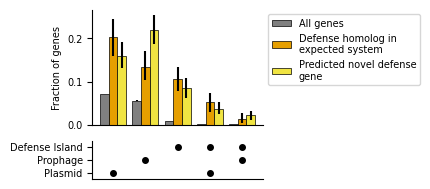

In [29]:
plot_upset(
    merged_hit_loc_agg_df, ['Plasmid', 'Prophage', 'Defense Island'], 'hit_cat_frac', 'hit_category',
    figsize=(2.2, 2.2),
    palette=defense_type_palette,  # Custom color palette
    subplot_fraction=0.25,           # Subplot is 25% of the bar plot height
    lower_bound='lower_bound_lb',
    upper_bound='hit_cat_frac_ub',
    legend_title=None, bar_ylabel='Fraction of genes', 
    marker_size=4, legend_text_width=25
)
plt.savefig('../figures/hit_type_distribution.svg', bbox_inches='tight', dpi=300)

##### Old code

In [20]:
hit_indices = ecor_predictions[~ecor_predictions['hit_category'].isna()].index
neighbor_reach = 5
hit_neighborhood_list = []
for i in tqdm(hit_indices):
    neighborhood_df = ecor_predictions.iloc[(i-neighbor_reach):(i+neighbor_reach+1), :]
    neighborhood_df = neighborhood_df.loc[neighborhood_df['hit_category'].isna()]
    hit_neighborhood_list.append(neighborhood_df)
hit_neighborhood_df = pd.concat(hit_neighborhood_list).drop_duplicates()

100%|██████████| 2563/2563 [00:01<00:00, 1824.19it/s]


### Gene associations

In [21]:
hit_neighborhood_df['name'].value_counts().head(20)

name
hypothetical protein                                        1329
site-specific integrase                                       61
phage portal protein                                          56
helix-turn-helix domain-containing protein                    53
phage tail protein                                            53
YjcZ-like family protein                                      46
MFS transporter                                               45
tyrosine-type recombinase/integrase                           44
N-acetylneuraminate epimerase                                 40
MoxR family ATPase                                            40
transposase                                                   34
replication endonuclease                                      34
endoribonuclease SymE                                         34
integrase arm-type DNA-binding domain-containing protein      33
terminase ATPase subunit family protein                       32
DUF945 domain-contai

#### Transposase

In [23]:
gene_names = ecor_predictions['name'].drop_duplicates()
trasposase_regex = 'transposase'
transposase_names = gene_names[gene_names.str.contains(trasposase_regex)]
ecor_predictions['transposase'] = ecor_predictions['name'].isin(transposase_names)

In [24]:
for window_size in np.arange(3, 25, 2):
    print(window_size)
    contig_tn_neighbor_list = []
    for contig, contig_df in tqdm(ecor_predictions.groupby('genomic_accession'), 
                                  position=0, total=ecor_predictions['genomic_accession'].nunique()):
        transposase_neighbor = (contig_df['transposase'].rolling(window_size, min_periods=1, center=True)
                                .max())
        out_contig_df = contig_df[['protein_context_id', 'predicted_defense']].copy()
        out_contig_df['transposase_neighbor'] = pd.Series(transposase_neighbor).astype(bool)
        contig_tn_neighbor_list.append(out_contig_df)
    tn_neighbor_df = pd.concat(contig_tn_neighbor_list)
    defense_tn_assoc = ((tn_neighbor_df['predicted_defense'] & 
                     tn_neighbor_df['transposase_neighbor']).sum()/
                    tn_neighbor_df['predicted_defense'].sum())
    background_tn_assoc = tn_neighbor_df['transposase_neighbor'].sum()/len(tn_neighbor_df)
    defense_tn_enrichment = defense_tn_assoc/background_tn_assoc
    print(defense_tn_enrichment)

3


100%|██████████| 7738/7738 [00:09<00:00, 833.16it/s]


1.4542943197463103
5


100%|██████████| 7738/7738 [00:09<00:00, 847.33it/s]


2.2737998105468877
7


100%|██████████| 7738/7738 [00:09<00:00, 830.72it/s]


2.688371691771988
9


100%|██████████| 7738/7738 [00:09<00:00, 847.72it/s]


2.8569224216623983
11


100%|██████████| 7738/7738 [00:09<00:00, 836.40it/s]


2.971279197416707
13


100%|██████████| 7738/7738 [00:09<00:00, 832.58it/s]


3.0382816760785833
15


100%|██████████| 7738/7738 [00:09<00:00, 824.03it/s]


2.9756414737204
17


100%|██████████| 7738/7738 [00:09<00:00, 850.61it/s]


2.868669989027652
19


100%|██████████| 7738/7738 [00:09<00:00, 835.58it/s]


2.8060818145088158
21


100%|██████████| 7738/7738 [00:09<00:00, 853.32it/s]


2.7444576985693425
23


100%|██████████| 7738/7738 [00:09<00:00, 836.07it/s]


2.718415344811743


In [25]:
window_size = 13
contig_tn_neighbor_list = []
for contig, contig_df in tqdm(ecor_predictions.groupby('genomic_accession'), 
                              position=0, total=ecor_predictions['genomic_accession'].nunique()):
    transposase_neighbor = (contig_df['transposase'].rolling(window_size, min_periods=1, center=True)
                            .max())
    out_contig_df = contig_df[['protein_context_id']].copy()
    out_contig_df['transposase_neighbor'] = pd.Series(transposase_neighbor).astype(bool)
    contig_tn_neighbor_list.append(out_contig_df)
tn_neighbor_df = pd.concat(contig_tn_neighbor_list)

100%|██████████| 7738/7738 [00:08<00:00, 895.57it/s]


In [26]:
ecor_predictions = ecor_predictions.merge(tn_neighbor_df, how='inner', 
                                          on='protein_context_id')

#### Integrase

In [27]:
gene_names = ecor_predictions['name'].drop_duplicates()
integrase_regex = 'integrase'
integrase_names = gene_names[gene_names.str.contains(integrase_regex)]
ecor_predictions['integrase'] = ecor_predictions['name'].isin(integrase_names)

In [28]:
for window_size in np.arange(3, 25, 2):
    print(window_size)
    contig_int_neighbor_list = []
    for contig, contig_df in tqdm(ecor_predictions.groupby('genomic_accession'), 
                                  position=0, total=ecor_predictions['genomic_accession'].nunique()):
        integrase_neighbor = (contig_df['integrase'].rolling(window_size, min_periods=1, center=True)
                                .max())
        out_contig_df = contig_df[['protein_context_id', 'predicted_defense']].copy()
        out_contig_df['integrase_neighbor'] = pd.Series(integrase_neighbor).astype(bool)
        contig_int_neighbor_list.append(out_contig_df)
    int_neighbor_df = pd.concat(contig_int_neighbor_list)
    defense_int_assoc = ((int_neighbor_df['predicted_defense'] & 
                     int_neighbor_df['integrase_neighbor']).sum()/
                    int_neighbor_df['predicted_defense'].sum())
    background_int_assoc = int_neighbor_df['integrase_neighbor'].sum()/len(int_neighbor_df)
    defense_int_enrichment = defense_int_assoc/background_int_assoc
    print(defense_int_enrichment)

3


100%|██████████| 7738/7738 [00:09<00:00, 825.45it/s]


4.445718180730064
5


100%|██████████| 7738/7738 [00:09<00:00, 827.47it/s]


5.406688548938497
7


100%|██████████| 7738/7738 [00:09<00:00, 844.73it/s]


5.149749852458464
9


100%|██████████| 7738/7738 [00:09<00:00, 846.18it/s]


5.173104795172727
11


100%|██████████| 7738/7738 [00:09<00:00, 845.05it/s]


5.072174218732193
13


100%|██████████| 7738/7738 [00:09<00:00, 845.09it/s]


5.087776533933896
15


100%|██████████| 7738/7738 [00:09<00:00, 846.40it/s]


5.105571119874065
17


100%|██████████| 7738/7738 [00:09<00:00, 847.20it/s]


5.082942286804947
19


100%|██████████| 7738/7738 [00:09<00:00, 848.55it/s]


5.126319835297616
21


100%|██████████| 7738/7738 [00:09<00:00, 831.99it/s]


5.1061814546070385
23


100%|██████████| 7738/7738 [00:09<00:00, 830.67it/s]


4.904471142273801


In [29]:
window_size = 5
contig_int_neighbor_list = []
for contig, contig_df in tqdm(ecor_predictions.groupby('genomic_accession'), 
                              position=0, total=ecor_predictions['genomic_accession'].nunique()):
    integrase_neighbor = (contig_df['integrase'].rolling(window_size, min_periods=1, center=True)
                            .max())
    out_contig_df = contig_df[['protein_context_id']].copy()
    out_contig_df['integrase_neighbor'] = pd.Series(integrase_neighbor).astype(bool)
    contig_int_neighbor_list.append(out_contig_df)
int_neighbor_df = pd.concat(contig_int_neighbor_list)

100%|██████████| 7738/7738 [00:08<00:00, 889.68it/s]


In [30]:
ecor_predictions = ecor_predictions.merge(int_neighbor_df, how='inner', 
                                          on='protein_context_id')

In [31]:
ecor_predictions['MGE'] = (ecor_predictions['prophage'] | ecor_predictions['plasmid'] |
                           ecor_predictions['transposase'] | ecor_predictions['integrase'])

In [32]:
def get_mge_stats(predictions):
    mge_stat_list = []
    N = len(predictions)
    known_defense_n = predictions['defense_system_protein'].sum()
    predicted_novel_n = (predictions['hit_category'] == 'Predicted novel defense gene').sum()
    for mge_col in [
                    'prophage', 'plasmid','MGE']:
        # Background
        mge_N = predictions[mge_col].sum()
        mge_stat_list.append({'mge_type': mge_col,
                              'category': 'All genes',
                              'numerator': mge_N,
                              'denominator': N,
                              'frac': mge_N/N})
        # Known defense
        mge_kd_n = (predictions[mge_col] & predictions['defense_system_protein']).sum()
        mge_stat_list.append({'mge_type': mge_col,
                              'category': 'Defense homolog in expected system',
                              'numerator': mge_kd_n,
                              'denominator': known_defense_n,
                              'frac': mge_kd_n/known_defense_n})
        # Novel defense
        mge_nd_n = (predictions[mge_col] & (predictions['hit_category'] == 
                                                 'Predicted novel defense gene')).sum()
        mge_stat_list.append({'mge_type': mge_col,
                              'category': 'Novel predicted defense protein',
                              'numerator': mge_nd_n,
                              'denominator': predicted_novel_n,
                              'frac': mge_nd_n/predicted_novel_n})
    mge_stat_df = pd.DataFrame(mge_stat_list)
    return mge_stat_df

In [33]:
n_boot = 200
all_mge_stat_list = list()
for i in tqdm(range(n_boot)):
    resampled_predictions = ecor_predictions.sample(frac=1, replace=True, random_state=i)
    mge_stat_df = get_mge_stats(resampled_predictions)
    mge_stat_df['trial'] = i
    all_mge_stat_list.append(mge_stat_df)
all_mge_stat_df = pd.concat(all_mge_stat_list)

100%|██████████| 200/200 [00:59<00:00,  3.38it/s]


In [34]:
agg_mge_stat_df = (all_mge_stat_df.groupby(['mge_type', 'category'])
                   .agg(mean_frac=('frac', 'mean'), 
                        upper_bound=('frac', lambda x: np.percentile(x, 97.5)), 
                        lower_bound=('frac', lambda x: np.percentile(x, 2.5)))
                   .reset_index())

In [35]:
mge_stat_df = get_mge_stats(ecor_predictions)
mge_stat_df = (mge_stat_df.merge(agg_mge_stat_df, how='inner', 
                                 on=['mge_type', 'category']))
mge_stat_df['display_mge'] = mge_stat_df['mge_type'].replace({'transposase_neighbor': 'Transposase associated', 
                                                          'integrase_neighbor': 'Integrase associated', 
                                                              'plasmid': 'Plasmid', 
                                                              'prophage': 'Prophage'})
mge_stat_df['display_mge'] = pd.Categorical(mge_stat_df['display_mge'], 
                                            categories=['MGE', 'Plasmid', 'Prophage', 
                                                        'Integrase associated', 
                                                        'Transposase associated'])
mge_stat_df['category'] = pd.Categorical(mge_stat_df['category'], 
                                         categories=['All genes', 'Defense homolog in expected system', 
                                                     'Novel predicted defense protein'])

In [37]:
def plot_bar_with_error_flipped(data, x, y, hue, lower_bound, upper_bound, 
                                width=0.25, palette=None, legend=True, ax=None, 
                                legend_loc='lower right'):
    """
    Plots a horizontal bar plot with error bars from a DataFrame.

    Parameters:
    data (pd.DataFrame): DataFrame containing the data to plot.
    x (str): Column name for the x-axis categories.
    y (str): Column name for the y-axis values.
    hue (str): Column name for the hue groups.
    lower_bound (str): Column name for the lower error bounds.
    upper_bound (str): Column name for the upper error bounds.
    width (float, optional): Width of the bars. Default is 0.25.
    palette (list, optional): List of colors to use for the different hues. Default is None.
    legend (bool, optional): Whether to display the legend. Default is True.
    ax (matplotlib.axes.Axes, optional): Axes object to draw the plot onto. Default is None.
    legend_loc (str, optional): Location of the legend. Default is 'lower right'.
    """
    x_labels = data[x].unique()
    hues = data[hue].unique()
    y_indices = np.arange(len(x_labels))
    multiplier = 0

    if ax is None:
        fig, ax = plt.subplots(layout='constrained')

    if palette is None:
        palette = plt.cm.tab10(np.linspace(0, 1, len(hues)))

    for idx, hue_val in enumerate(hues):
        subset = data[data[hue] == hue_val]
        measurements = subset[y].values
        lower_bounds = measurements - subset[lower_bound].values
        upper_bounds = subset[upper_bound].values - measurements
        error = [lower_bounds, upper_bounds]
        offset = width * multiplier
        rects = ax.barh(y_indices + offset, measurements, width, label=hue_val, xerr=error, color=palette[idx], 
                        edgecolor='black', linewidth=0.5)
        multiplier += 1

    # Add labels, title and custom y-axis tick labels, etc.
    ax.set_yticks(y_indices + width * (len(hues) - 1) / 2, x_labels)
    
    if legend:
        ax.legend(loc='lower left', bbox_to_anchor=(0.5, 0.1), ncols=1)

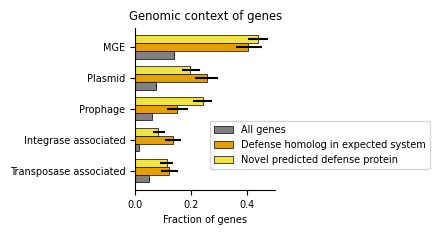

In [38]:
_, ax = plt.subplots(figsize=(1.8, 2.1))
plot_bar_with_error_flipped(data=mge_stat_df, y='frac', x='display_mge', 
                    hue='category', lower_bound='lower_bound', 
                    upper_bound='upper_bound', palette=defense_type_palette, ax=ax)
sns.despine()
plt.xlabel('Fraction of genes')
plt.title('Genomic context of genes')
plt.savefig('../figures/mge_association.svg', dpi=300, bbox_inches='tight')

In [42]:
def get_dfn_stats(predictions):
    dfn_stat_list = []
    N = len(predictions)
    known_defense_n = predictions['defense_system_protein'].sum()
    predicted_novel_n = (predictions['hit_category'] == 'Predicted novel defense gene').sum()
    # Background
    dfn_N = predictions['defense_neighbor'].sum()
    dfn_stat_list.append({'category': 'All genes',
                          'numerator': dfn_N,
                          'denominator': N,
                          'frac': dfn_N/N})
    # Known defense
    dfn_kd_n = (predictions['defense_neighbor'] & predictions['defense_system_protein']).sum()
    dfn_stat_list.append({'category': 'Defense homolog in expected system',
                          'numerator': dfn_kd_n,
                          'denominator': known_defense_n,
                          'frac': dfn_kd_n/known_defense_n})
    # Novel defense
    dfn_nd_n = (predictions['defense_neighbor'] & (predictions['hit_category'] == 
                                                   'Predicted novel defense gene')).sum()
    dfn_stat_list.append({'category': 'Novel predicted defense protein',
                          'numerator': dfn_nd_n,
                          'denominator': predicted_novel_n,
                          'frac': dfn_nd_n/predicted_novel_n})
    dfn_stat_df = pd.DataFrame(dfn_stat_list)
    return dfn_stat_df

In [43]:
n_boot = 200
all_dfn_stat_list = list()
for i in tqdm(range(n_boot)):
    resampled_predictions = ecor_predictions.sample(frac=1, replace=True, random_state=i)
    dfn_stat_df = get_dfn_stats(resampled_predictions)
    dfn_stat_df['trial'] = i
    all_dfn_stat_list.append(dfn_stat_df)
all_dfn_stat_df = pd.concat(all_dfn_stat_list)

100%|██████████| 200/200 [00:53<00:00,  3.75it/s]


In [44]:
agg_dfn_stat_df = (all_dfn_stat_df.groupby(['category'])
                   .agg(mean_frac=('frac', 'mean'), 
                        upper_bound=('frac', lambda x: np.percentile(x, 97.5)), 
                        lower_bound=('frac', lambda x: np.percentile(x, 2.5)))
                   .reset_index())

In [45]:
dfn_stat_df = get_dfn_stats(ecor_predictions)
dfn_stat_df = (dfn_stat_df.merge(agg_dfn_stat_df, how='inner', 
                                 on=['category']))
dfn_stat_df['category'] = pd.Categorical(dfn_stat_df['category'], 
                                         categories=['All genes', 'Defense homolog in expected system', 
                                                     'Novel predicted defense protein'])
dfn_stat_df['mge_type'] = 'Defense Island'
dfn_stat_df['display_mge'] = 'Defense Island'

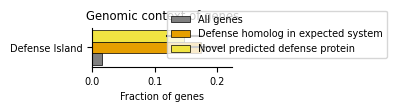

In [46]:
_, ax = plt.subplots(figsize=(1.8, 0.5))
plot_bar_with_error_flipped(data=dfn_stat_df, y='frac', x='mge_type', 
                    hue='category', lower_bound='lower_bound', 
                    upper_bound='upper_bound', palette=defense_type_palette, ax=ax)
sns.despine()
plt.xlabel('Fraction of genes')
plt.title('Genomic context of genes')
plt.savefig('../figures/dfn_association.svg', dpi=300, bbox_inches='tight')

In [47]:
cat_dfn_mge = pd.concat([mge_stat_df, dfn_stat_df])
cat_dfn_mge['display_category'] = pd.Categorical(
    cat_dfn_mge['category'].replace({'Defense homolog in expected system':
                                     'Defense homolog\nin expected system', 
                                     'Novel predicted defense protein': 
                                     'Novel predicted\ndefense protein'}), 
    categories=['All genes',
                'Defense homolog\nin expected system',
                'Novel predicted\ndefense protein'])

In [49]:
cat_dfn_mge

,mge_type,category,numerator,denominator,frac,mean_frac,upper_bound,lower_bound,display_mge,display_category
0,transposase_neighbor,All genes,16259,321347,0.050596,0.050608,0.051353,0.049849,Transposase associated,All genes
1,transposase_neighbor,Defense homolog in expected system,48,395,0.121519,0.121363,0.154313,0.090844,Transposase associated,Defense homolog\nin expected system
2,transposase_neighbor,Novel predicted defense protein,68,607,0.112026,0.111364,0.134562,0.088474,Transposase associated,Novel predicted\ndefense protein
3,integrase_neighbor,All genes,4035,321347,0.012557,0.012558,0.012961,0.012177,Integrase associated,All genes
4,integrase_neighbor,Defense homolog in expected system,53,395,0.134177,0.133570,0.163658,0.105667,Integrase associated,Defense homolog\nin expected system
5,integrase_neighbor,Novel predicted defense protein,50,607,0.082372,0.082198,0.106088,0.063631,Integrase associated,Novel predicted\ndefense protein
6,prophage,All genes,18886,321347,0.058771,0.058767,0.059568,0.058121,Prophage,All genes
7,prophage,Defense homolog in expected system,59,395,0.149367,0.150267,0.189019,0.112724,Prophage,Defense homolog\nin expected system
8,prophage,Novel predicted defense protein,147,607,0.242175,0.240414,0.275399,0.205636,Prophage,Novel predicted\ndefense protein
9,plasmid,All genes,24164,321347,0.075196,0.075228,0.076046,0.074398,Plasmid,All genes


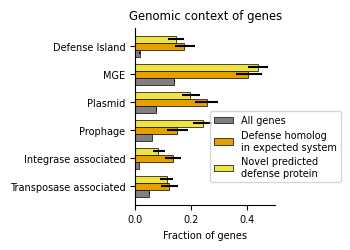

In [48]:
_, ax = plt.subplots(figsize=(1.8, 2.3))
plot_bar_with_error_flipped(data=cat_dfn_mge, y='frac', x='display_mge', 
                    hue='display_category', lower_bound='lower_bound', 
                    upper_bound='upper_bound', palette=defense_type_palette, ax=ax)
sns.despine()
plt.xlabel('Fraction of genes')
plt.title('Genomic context of genes')
plt.savefig('../figures/mge_dfn_association.svg', dpi=300, bbox_inches='tight')